# Classifcation Models

In [579]:
#General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier #AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

#Hiding Pink Warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
sns.set_style('white')

In [478]:
def grid_results(model,norm):
    """
    parameters:
        model = takes in a fitted grid search model and retrieves the accuracy scores for it based on the train test split variables
        norm = 'true' or 'false' (string) - Idicates whether to normalize the Confusion Matrix or not
    """
    print('--------------------------------------------------')
    print(model.best_estimator_)
    print('Best Parameters for pipe model:')
    for key in model.best_params_:
        print(f'    {key}: {model.best_params_[key]}')
    print(model.score(X_train, y_train), model.score(X_test, y_test))
    ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,cmap='Blues',normalize=norm);
    print('--------------------------------------------------')

## Table of Contents:
1. Reading Data and Train Test Splitting
2. Null Model
3. Logistic Regression with Count Vectorizer including the fire emojis
4. Logistic Regression with Count Vectorizer
5. Grid Search on Logistic Regression with Count Vectorizer
6. Grid Search on Logistic Regression with Tfidf Vectorizer
7. Grid Search on K Neighbors Classifier with Count Vectorizer
8. Grid Search on Random Forest with Count Vectorizer
9. Grid Search on Extremely Random Trees with Count Vectorizer
10. Grid Search on Multinomial Naive Bayes with Count Vectorizer
11. Grid Search on Multinomial Naive Bayes with Tfidf Vectorizer
12. Voting Classifier - Ensemble Model
13. Model Coefficients - (Logistic Regression Count Vectorizer)

## 1) Reading and Splitting the Data

In [429]:
data = pd.read_csv('../data/edited_data.csv')
data['title_include_fire'] = data['title'].str.replace('🔥',' emote_fire ')

In [432]:
data.tail()

,subreddit,selftext,title,title_length,title_word_count,title_include_fire
9991,NatureIsFuckingLit,NaN,🔥 Trio of Hyacinth Macaws,25,5,emote_fire Trio of Hyacinth Macaws
9992,NatureIsFuckingLit,NaN,Beautiful mountains,19,2,Beautiful mountains
9993,NatureIsFuckingLit,NaN,🔥 Eagle flying with a camera,28,6,emote_fire Eagle flying with a camera
9994,NatureIsFuckingLit,NaN,Art,3,1,Art
9995,NatureIsFuckingLit,NaN,"Anxiety healing, relaxing nature &amp; calming...",54,7,"Anxiety healing, relaxing nature &amp; calming..."


### Train Test Splitting the Data

In [51]:
X = data['title']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

## 2) <u>Null Model</u>

In [433]:
y_test.value_counts(normalize=True)

natureismetal         0.5002
NatureIsFuckingLit    0.4998
Name: subreddit, dtype: float64

#### Baseline Accuracy = 50.02%
#### Model will need to predict subreddits with an accuracy above 50% to be significant

### Applying Count Vectorizer to X train and test data

In [434]:
cv = CountVectorizer(lowercase=True,stop_words='english',min_df=3)

X_train_cv = cv.fit_transform(X_train).A
X_test_cv = cv.transform(X_test).A

feature_names = cv.get_feature_names_out()

X_train_cv = pd.DataFrame(X_train_cv, columns=feature_names)
X_test_cv = pd.DataFrame(X_test_cv, columns=feature_names)

X_train_cv.sum().sort_values(ascending=False).head(10)

tree      238
nature    221
oc        203
park      162
eating    158
like      157
bird      156
fish      149
red       142
hawk      137
dtype: int64

#### Visualizing the most common words in X_train and X_test

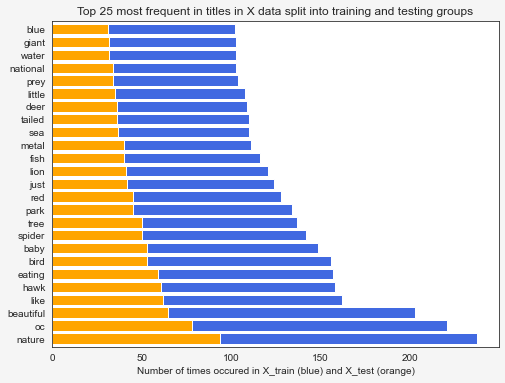

In [449]:
plt.figure(figsize=(8,6),facecolor='whitesmoke')
X_train_cv.sum().sort_values(ascending=False).head(25).plot(kind='barh',color='royalblue',width=0.8);
X_test_cv.sum().sort_values(ascending=False).head(25).plot(kind='barh',color='orange',width=0.8);
plt.xlabel('Number of times occured in X_train (blue) and X_test (orange)')
plt.title('Top 25 most frequent in titles in X data split into training and testing groups');

## 3) <u>Logistic Regression with Count Vectorizer</u>  **including the fire emojis**

#### Making a unique train test split for data that includes the fire emoji 

In [439]:
X_fire = data['title_include_fire']
y_fire = data['subreddit']

X_train_fire, X_test_fire, y_train_fire, y_test_fire = train_test_split(X_fire,y_fire,random_state=42,stratify=y_fire)

In [441]:
cv_fire = CountVectorizer(lowercase=True,stop_words='english',min_df=3)

X_train_fire_cv = cv_fire.fit_transform(X_train_fire).A
X_test_fire_cv = cv_fire.transform(X_test_fire).A

feature_names = cv_fire.get_feature_names_out()

X_train_fire_cv = pd.DataFrame(X_train_fire_cv, columns=feature_names)
X_test_fire_cv = pd.DataFrame(X_test_fire_cv, columns=feature_names)

X_train_fire_cv.sum().sort_values(ascending=False).head(3)

emote_fire    2538
tree           238
nature         221
dtype: int64

In [443]:
log_reg_fire = LogisticRegression(max_iter=1_000, n_jobs=-1)
log_reg_fire.fit(X_train_fire_cv, y_train_fire)
log_reg_fire.score(X_train_fire_cv, y_train_fire), log_reg_fire.score(X_test_fire_cv, y_test_fire)

(0.9163665466186475, 0.8271308523409364)

#### Counting the Fire Emojis as valid words in the titles results in a basic Logistic Regression having a test accuracy score of  82.7%, 6% higher than our ensemble VotingClassifier model.

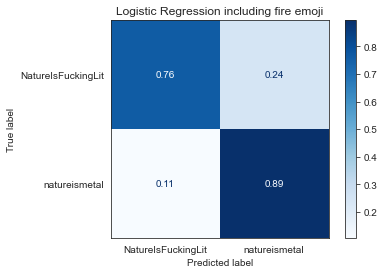

In [584]:
ConfusionMatrixDisplay.from_estimator(log_reg_fire,X_test_fire_cv,y_test_fire,normalize='true',cmap='Blues');
plt.title('Logistic Regression including fire emoji');

#### Despite the majority of r/NatureisLit posts being identifiable through the fire emoji, the model is surprisingly inaccurate with an 83% accuracy rate. This shows that the two subreddits share enough title vocabulary to keep them from being effortlessly distinguishable by NatureIsLit's fire emoji rule. 

## 4) <u>Logistic Regression with Count Vectorizer</u>

In [127]:
log_reg = LogisticRegression(max_iter=1_000, n_jobs=-1)
log_reg.fit(X_train_cv, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [128]:
log_reg.score(X_train_cv, y_train), log_reg.score(X_test_cv, y_test)

(0.8667466986794717, 0.7410964385754302)

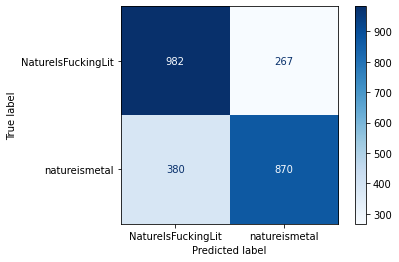

In [129]:
ConfusionMatrixDisplay.from_estimator(log_reg,X_test_cv,y_test, cmap='Blues');

#### Test Accuracy: 74.11%

## 5) <u>Grid Search on Logistic Regression with CV</u>

In [459]:
lr_cv_pipe = Pipeline([
    ('cv', CountVectorizer(lowercase = True, stop_words='english')),
    ('lr', LogisticRegression(max_iter=10_000, n_jobs=-1))
])

#### [Here](https://stackoverflow.com/questions/57333183/sk-learn-countvectorizer-keeping-emojis-as-words) is where I got the token pattern to keep emojis in the count vectorizer

In [460]:
params = {
    'lr__C': [0.1, 1.0, 10.0],
    'cv__strip_accents': [None,'unicode','ascii'],
    #'cv__token_pattern':[r'[^\s]+','(?u)\\b\\w\\w+\\b'], #first pattern keeps emojis and other symbols, second one is the default pattern
    'cv__ngram_range': [(1, 1),(1, 2),(2, 2),(1,3),(2,3),(3,3)], 
    'cv__min_df': [1,2,3,10,20],
    'cv__max_df': [0.7, 0.85, 1.0]
}

In [461]:
lr_cv_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('lr', LogisticRegression(max_iter=10000, n_jobs=-1))])

In [462]:
lr_cv_pipe.score(X_train, y_train), lr_cv_pipe.score(X_test, y_test)

(0.9233026543950914, 0.7539015606242497)

In [463]:
lr_cv_gs = GridSearchCV(lr_cv_pipe, params, n_jobs=-1)

In [464]:
lr_cv_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('lr',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.7, 0.85, 1.0],
                         'cv__min_df': [1, 2, 3, 10, 20],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                             (2, 3), (3, 3)],
                         'cv__strip_accents': [None, 'unicode', 'ascii'],
                         'lr__C': [0.1, 1.0, 10.0]})

--------------------------------------------------
Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.7, ngram_range=(1, 2),
                                 stop_words='english', strip_accents='ascii')),
                ('lr', LogisticRegression(max_iter=10000, n_jobs=-1))])
Best Parameters for pipe model:
    cv__max_df: 0.7
    cv__min_df: 1
    cv__ngram_range: (1, 2)
    cv__strip_accents: ascii
    lr__C: 1.0
0.9745231425903694 0.7607042817126851
--------------------------------------------------


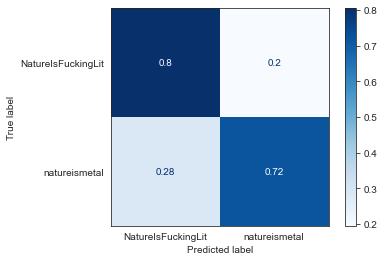

In [479]:
grid_results(lr_cv_gs,'true')

#### **Logistic Regression Test Accuracy Score: 76.07%**

#### If you uncomment the token pattern line in the paramter set, the grid search compares two parameters.
#### The first, r'[^\s]+' tells the count vectorizer method not to remove emojis from the titles. The second one is the default token pattern. Using the "emoji pattern" will result in a test accuracy score of approximately 80%, 3.9% higher than the score listed above.
#### However, I choose not to incorporate this parameter into my final model as it also enables characters such as "-" to be counted as words, which degrades the model as the intention of this project is to classify posts based on the english words in their titles. If I want to include the fire emojis, i can replace them with english identifiers in the initial DataFrame read from our csv file.

## 6) <u>Grid Search on Logistic Regression with Tfidf Vectorizer</u>

In [327]:
lr_tf_pipe = Pipeline([
    ('tf', TfidfVectorizer(lowercase=True,stop_words='english')),
    ('lr', LogisticRegression(max_iter=10_000, n_jobs=-1))
])

In [328]:
lr_tf_params = {
    'lr__C': [0.1, 1.0, 10.0],
    'tf__strip_accents': [None,'unicode','ascii'],
    'tf__ngram_range': [(1, 1),(1, 2),(2, 2),(1,3),(2,3),(3,3)], 
    'tf__min_df': [1,2,3,10,20],
    'tf__max_df': [0.7, 0.85, 1.0]
}

In [329]:
lr_tf_gs = GridSearchCV(lr_tf_pipe, lr_tf_params, n_jobs=-1)

In [330]:
lr_tf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lr',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1.0, 10.0],
                         'tf__max_df': [0.7, 0.85, 1.0],
                         'tf__min_df': [1, 2, 3, 10, 20],
                         'tf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                             (2, 3), (3, 3)],
                         'tf__strip_accents': [None, 'unicode', 'ascii']})

--------------------------------------------------
Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.7, ngram_range=(1, 3),
                                 stop_words='english',
                                 strip_accents='unicode')),
                ('lr', LogisticRegression(C=10.0, max_iter=10000, n_jobs=-1))])
Best Parameters for pipe model:
    lr__C: 10.0
    tf__max_df: 0.7
    tf__min_df: 1
    tf__ngram_range: (1, 3)
    tf__strip_accents: unicode
0.9858610110710951 0.7619047619047619
--------------------------------------------------


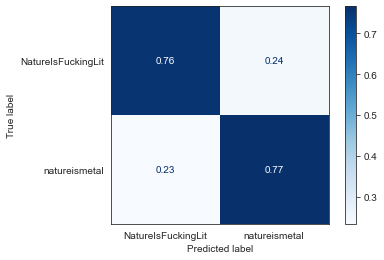

In [480]:
grid_results(lr_tf_gs,'true')

#### Accuracy Score: 76.19%

## 7) <u>Grid Search on KNeighbors Classifier + CV</u>

In [253]:
knn_pipe = Pipeline([
    ('cv', CountVectorizer(lowercase = True, stop_words='english')),
    ('knn', KNeighborsClassifier())
])

#### Will not be using a max_df parameter in KNN grid search as it made absolutely no difference to the Logistic Regression Model and will significantly increase the processing time for the KNN grid search.

In [254]:
knn_params = {
    'cv__strip_accents': [None,'unicode','ascii'],
    'cv__ngram_range': [(1, 1),(1, 2),(2, 2),(1,3),(2,3),(3,3)], 
    'cv__min_df': [1,2,3,10,20],
    'knn__n_neighbors': [3, 5, 7, 10, 15],
    'knn__weights': ['uniform', 'distance']
}

In [255]:
knn_gs = GridSearchCV(knn_pipe, knn_params, n_jobs=-1)

In [256]:
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cv__min_df': [1, 2, 3, 10, 20],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                             (2, 3), (3, 3)],
                         'cv__strip_accents': [None, 'unicode', 'ascii'],
                         'knn__n_neighbors': [3, 5, 7, 10, 15],
                         'knn__weights': ['uniform', 'distance']})

--------------------------------------------------
Pipeline(steps=[('cv',
                 CountVectorizer(min_df=20, ngram_range=(1, 3),
                                 stop_words='english')),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])
Best Parameters for pipe model:
    cv__min_df: 20
    cv__ngram_range: (1, 3)
    cv__strip_accents: None
    knn__n_neighbors: 15
    knn__weights: distance
0.8756836067760437 0.6770708283313326
--------------------------------------------------


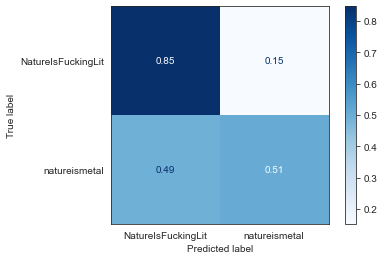

In [481]:
grid_results(knn_gs,'true')

#### KNearest Neighbors Test Accuracy Score: 67.7%

## 8) <u>Grid Search on Random Forest + CV</u>

In [286]:
rfc_pipe= Pipeline([
    ('cv', CountVectorizer(lowercase=True, stop_words='english')),
    ('rfc', RandomForestClassifier())
])

#### I am going to reduce the amount of parameters used for CountVectorizer to evaluate the Forest Classifier models in order to finish the project before 2023. If we use the same paramaters for the CV in this model as we did for KNN, there will be 4,860 parameter combinations for gridsearch to run.
#### I will be reducing CV parameters to values favored in the Logistic and KNN grid searches. This Grid Search will be run with 1080 parameter combinations.

In [291]:
rfc_params = {
    'cv__strip_accents': [None,'ascii'],
    'cv__ngram_range': [(1, 1),(1, 2),(1,3)],
    'cv__min_df': [1, 2, 3, 20],
    'rfc__n_estimators':[100, 150, 200],
    'rfc__max_depth': [None, 5, 7, 10, 15],
    'rfc__min_samples_split': [2, 3, 5],   
}

In [292]:
rfc_gs = GridSearchCV(rfc_pipe, rfc_params, n_jobs=-1)

In [293]:
rfc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cv__min_df': [1, 2, 3, 20],
                         'cv__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cv__strip_accents': [None, 'ascii'],
                         'rfc__max_depth': [None, 5, 7, 10, 15],
                         'rfc__min_samples_split': [2, 3, 5],
                         'rfc__n_estimators': [100, 150, 200]})

--------------------------------------------------
Pipeline(steps=[('cv',
                 CountVectorizer(stop_words='english', strip_accents='ascii')),
                ('rfc',
                 RandomForestClassifier(min_samples_split=5,
                                        n_estimators=150))])
Best Parameters for pipe model:
    cv__min_df: 1
    cv__ngram_range: (1, 1)
    cv__strip_accents: ascii
    rfc__max_depth: None
    rfc__min_samples_split: 5
    rfc__n_estimators: 150
0.9739895958383353 0.7543017206882753
--------------------------------------------------


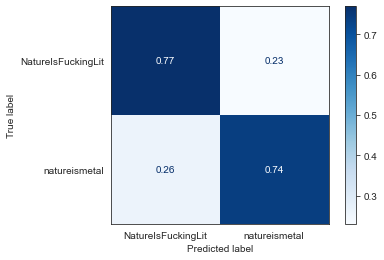

In [482]:
grid_results(rfc_gs,'true')

#### Accuracy Score: 75.43%

## 9) <u>Grid Search on Extremely Random Trees + CV</u>

In [386]:
etc_pipe= Pipeline([
    ('cv', CountVectorizer(lowercase=True, stop_words='english')),
    ('etc', ExtraTreesClassifier())
])

#### Paramaters further reduced from the Randomized Tree Grid Search in order to improve performance. The Grid Search for this model will be run with 288 parameter combinations.

In [387]:
etc_params = {
    'cv__strip_accents': ['ascii'],
    'cv__ngram_range': [(1, 1),(1,3)],
    'cv__min_df': [1, 2, 3, 20],
    'etc__n_estimators':[100, 150, 200],
    'etc__max_depth': [None, 5, 10, 15],
    'etc__min_samples_split': [2, 3, 5],   
}

In [389]:
etc_gs = GridSearchCV(etc_pipe, etc_params, n_jobs=-1)

In [390]:
etc_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('etc', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'cv__min_df': [1, 2, 3, 20],
                         'cv__ngram_range': [(1, 1), (1, 3)],
                         'cv__strip_accents': ['ascii'],
                         'etc__max_depth': [None, 5, 10, 15],
                         'etc__min_samples_split': [2, 3, 5],
                         'etc__n_estimators': [100, 150, 200]})

--------------------------------------------------
Pipeline(steps=[('cv',
                 CountVectorizer(stop_words='english', strip_accents='ascii')),
                ('etc', ExtraTreesClassifier(min_samples_split=5))])
Best Parameters for pipe model:
    cv__min_df: 1
    cv__ngram_range: (1, 1)
    cv__strip_accents: ascii
    etc__max_depth: None
    etc__min_samples_split: 5
    etc__n_estimators: 100
0.9826597305588902 0.7498999599839936
--------------------------------------------------


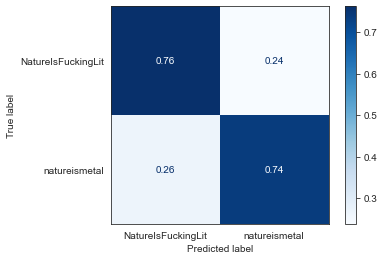

In [483]:
grid_results(etc_gs,'true')

#### Accuracy Score: 74.99%

## 10) <u>Grid Search on Multinomial Naive Bayes with CV</u>

In [344]:
mnb_cv_pipe= Pipeline([
    ('cv', CountVectorizer(lowercase=True, stop_words='english')),
    ('mnb', MultinomialNB())
])

In [345]:
mnb_cv_params = {
    'cv__strip_accents': [None,'unicode','ascii'],
    'cv__ngram_range': [(1, 1),(1, 2),(2, 2),(1,3),(2,3),(3,3)], 
    'cv__min_df': [1,2,3,10,20],
    'cv__max_df': [0.7, 0.85, 1.0]
}

In [346]:
mnb_gs = GridSearchCV(mnb_cv_pipe, mnb_cv_params, n_jobs=-1)

In [347]:
mnb_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.7, 0.85, 1.0],
                         'cv__min_df': [1, 2, 3, 10, 20],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                             (2, 3), (3, 3)],
                         'cv__strip_accents': [None, 'unicode', 'ascii']})

--------------------------------------------------
Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.7, ngram_range=(1, 2),
                                 stop_words='english', strip_accents='ascii')),
                ('mnb', MultinomialNB())])
Best Parameters for pipe model:
    cv__max_df: 0.7
    cv__min_df: 1
    cv__ngram_range: (1, 2)
    cv__strip_accents: ascii
0.9478458049886621 0.7643057222889156
--------------------------------------------------


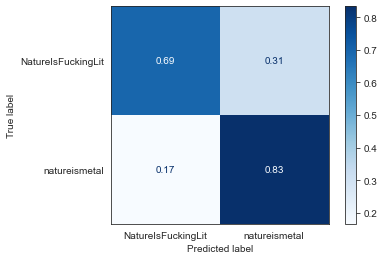

In [485]:
grid_results(mnb_gs,'true')

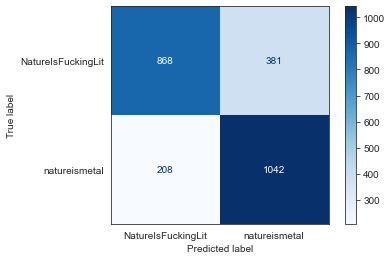

In [366]:
ConfusionMatrixDisplay.from_estimator(mnb_gs,X_test,y_test, cmap='Blues');

#### Accuracy Score: 76.43%

## 11) <u>Grid Search on Multinomial Naive Bayes with TfidfVectorizer</u>

In [354]:
mnb_tf_pipe = Pipeline([
    ('tf', TfidfVectorizer(lowercase=True,stop_words='english')),
    ('mnb', MultinomialNB())
])

In [355]:
mnb_tf_params = {
    'tf__strip_accents': [None,'unicode','ascii'],
    'tf__ngram_range': [(1, 1),(1, 2),(2, 2),(1,3),(2,3),(3,3)], 
    'tf__min_df': [1,2,3,10,20],
    'tf__max_df': [0.7, 0.85, 1.0]
}

In [356]:
mnb_tf_gs = GridSearchCV(mnb_tf_pipe, mnb_tf_params, n_jobs=-1)

In [357]:
mnb_tf_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tf__max_df': [0.7, 0.85, 1.0],
                         'tf__min_df': [1, 2, 3, 10, 20],
                         'tf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                             (2, 3), (3, 3)],
                         'tf__strip_accents': [None, 'unicode', 'ascii']})

--------------------------------------------------
Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.7, ngram_range=(1, 2),
                                 stop_words='english', strip_accents='ascii')),
                ('mnb', MultinomialNB())])
Best Parameters for pipe model:
    tf__max_df: 0.7
    tf__min_df: 1
    tf__ngram_range: (1, 2)
    tf__strip_accents: ascii
0.9485127384287048 0.7579031612645059
--------------------------------------------------


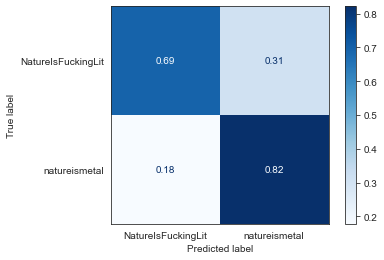

In [486]:
grid_results(mnb_tf_gs,'true')

### Comparing Tfidf and Count Vectorizer for Multinomial Naive Bayes Grid Search

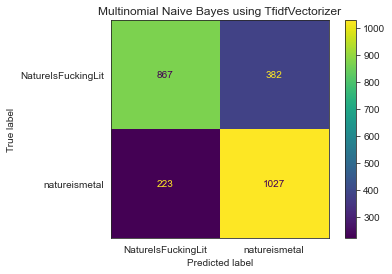

In [509]:
ConfusionMatrixDisplay.from_estimator(mnb_tf_gs,X_test,y_test, cmap='viridis')
plt.title('Multinomial Naive Bayes using TfidfVectorizer');

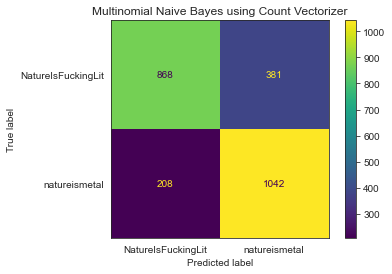

In [508]:
ConfusionMatrixDisplay.from_estimator(mnb_gs,X_test,y_test, cmap='viridis');
plt.title('Multinomial Naive Bayes using Count Vectorizer');

## 12) <u>Voting Classifier - Ensemble Model</u>

In [493]:
vc = VotingClassifier([
    ('mnb',mnb_gs.best_estimator_.named_steps.mnb), #Score of 76.43%
    ('lr',lr_tf_gs.best_estimator_.named_steps.lr), #Score of 76.19%
    ('etc',etc_gs.best_estimator_.named_steps.etc) #Score of 74.99%
], voting='soft',n_jobs=-1)

In [494]:
pipe_vc = Pipeline([
    ('tf', TfidfVectorizer()),
    ('vc', vc)
])

In [495]:
pipe_vc.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('vc',
                 VotingClassifier(estimators=[('mnb', MultinomialNB()),
                                              ('lr',
                                               LogisticRegression(C=10.0,
                                                                  max_iter=10000,
                                                                  n_jobs=-1)),
                                              ('etc',
                                               ExtraTreesClassifier(min_samples_split=5))],
                                  n_jobs=-1, voting='soft'))])

In [496]:
pipe_vc.score(X_train, y_train), pipe_vc.score(X_test, y_test)

(0.9733226623982927, 0.7683073229291717)

# Note: (0.972922502334267, 0.7675070028011205) is the train,test score at the time of presenting

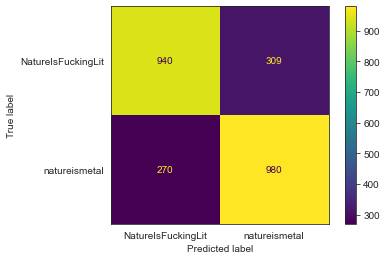

In [507]:
ConfusionMatrixDisplay.from_estimator(pipe_vc,X_test,y_test, cmap='viridis');

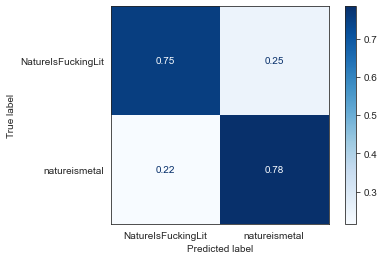

In [499]:
ConfusionMatrixDisplay.from_estimator(pipe_vc,X_test,y_test,normalize='true', cmap='Blues')

## 13) <u>Model Coefficients</u>

In [535]:
coefs = list(zip(lr_cv_pipe.named_steps.cv.get_feature_names_out(), lr_cv_pipe.named_steps.lr.coef_[0]))

In [542]:
word_importance = pd.DataFrame(coefs, columns=['word', 'coef']).sort_values('coef', ascending=False)

#### Words that affect if a post is assigned to r/natureismetal

#### **Example**: If a post title contains the word 'metal', it is 382.64% more likely to be classified as a r/naturismetal post than a post that does not contain the word 'metal', holding all else constant

In [545]:
word_importance.head(10)

,word,coef
5873,metal,2.826435
9486,tooth,2.145678
1614,catfish,2.073406
10413,zebra,2.021246
9476,tonga,1.928061
2477,dead,1.874156
6187,musicrelaxationsounds,1.729165
2634,devouring,1.638292
5090,kill,1.633893
5096,kills,1.633165


#### Words that affect if a post is assigned to r/natureisfuckinglit

#### **Example**: If a post title contains the word 'lit', it is 293% less likely to be classified as a r/naturismetal post than a post that does not contain the word 'lit', holding all else constant.

In [546]:
word_importance.tail(10)

,word,coef
381,albino,-1.314921
2039,complete,-1.335531
9143,switzerland,-1.449784
2955,easily,-1.470822
4588,iceland,-1.498355
1911,cloud,-1.499521
635,arizona,-1.576918
9059,sunset,-1.664141
4124,guide,-1.795370
5428,lit,-1.933484


#### Messing around with Decision Tree visuals, not super comfortable with these yet.

In [577]:
from sklearn.tree import plot_tree, export_text

In [ ]:
len(rfc_gs.best_estimator_[1].estimators_

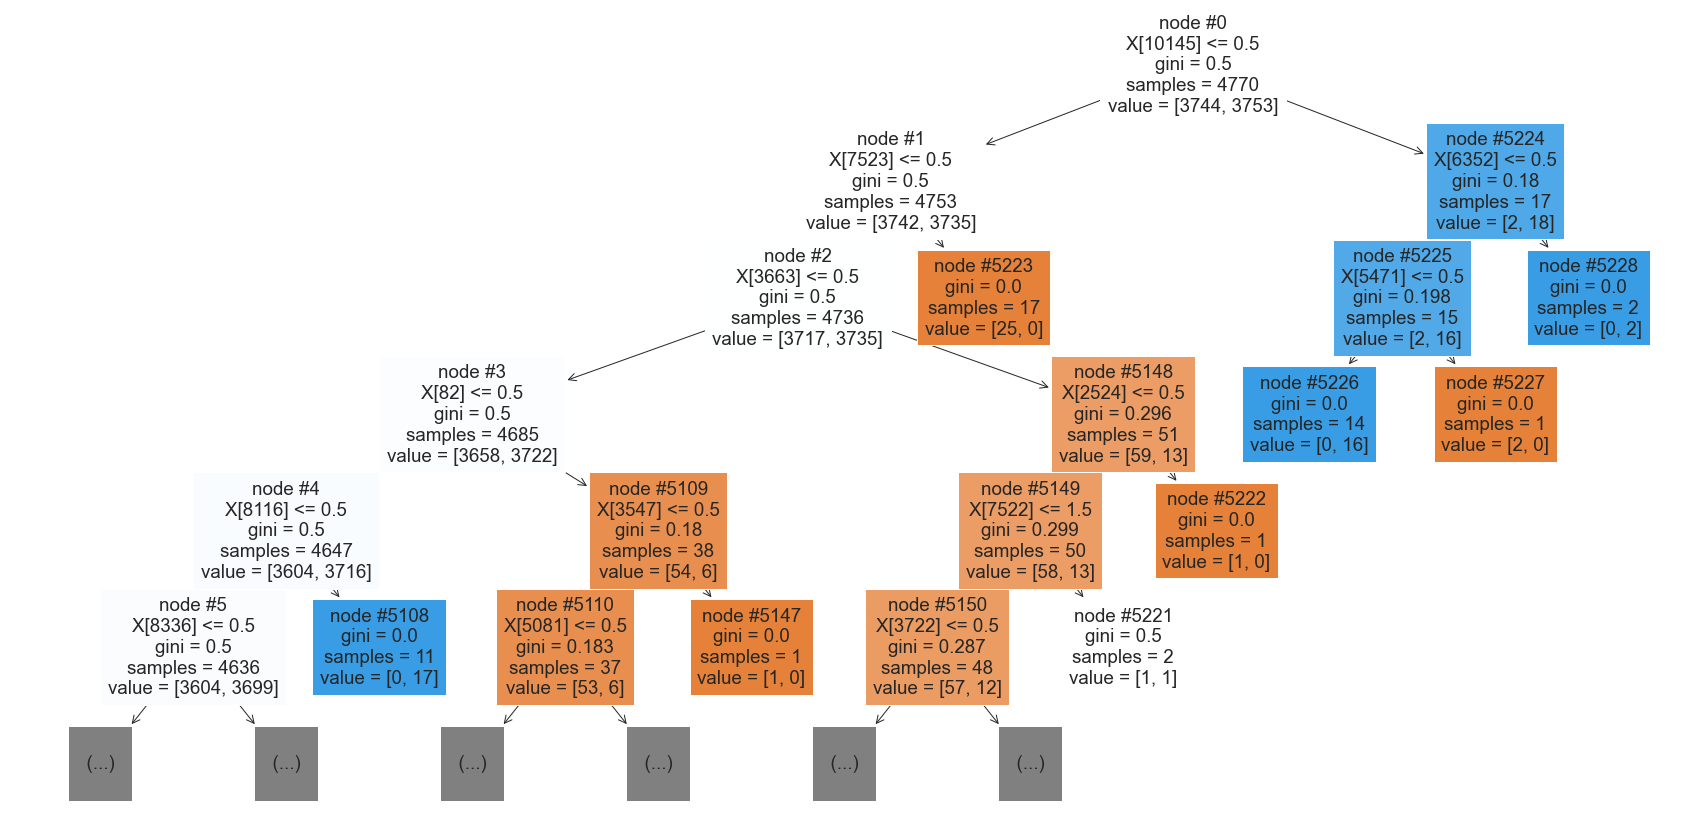

In [574]:
plt.figure(figsize=(30,15))
plot_tree(rfc_gs.best_estimator_[1].estimators_[0],max_depth=5, filled=True, node_ids=True);